In [1]:
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
scaler = MinMaxScaler()

edf = pd.read_csv('expenses dataset.csv')
sdf = pd.read_csv('sales dataset.csv')
edf['expenseDate'] = pd.to_datetime(edf['expenseDate'], infer_datetime_format=True)
sdf['salesDate'] = pd.to_datetime(sdf['salesDate'], infer_datetime_format=True)

In [2]:
selected_columns =['expenseAmount', 'expenseDate']
edf = edf[selected_columns]
selected_columns1 =['salesAmount', 'salesDate']
sdf = sdf[selected_columns1]

In [3]:
edf['eYear'] = edf['expenseDate'].dt.year
edf['eMonth'] = edf['expenseDate'].dt.month
edf['eDay'] = edf['expenseDate'].dt.day
sdf['sYear'] = sdf['salesDate'].dt.year
sdf['sMonth'] = sdf['salesDate'].dt.month
sdf['sDay'] = sdf['salesDate'].dt.day
##################
edf_daily = edf.groupby(['eYear','eMonth','eDay'])['expenseAmount'].sum().reset_index()
###################
sdf_daily = sdf.groupby(['sYear','sMonth', 'sDay'])['salesAmount'].sum().reset_index()

In [4]:
selected_columns3 = ['expenseAmount'] 
edf_daily = np.array(edf_daily[selected_columns3]).flatten()

In [5]:
edf_daily = edf_daily[131:]
len(edf_daily)

941

In [6]:
selected_columns4 = ['salesAmount'] 
sdf_daily = np.array(sdf_daily[selected_columns4]).flatten()
len(sdf_daily)

941

In [33]:
sdf_daily = [float(x) for x in sdf_daily]

In [34]:
actual = pd.DataFrame(data={'Sales': sdf_daily, 'Expenses':edf_daily})
hmm = actual
hmm

,Sales,Expenses
0,504170.0,134350.0
1,439435.0,204000.0
2,491330.0,40400.0
3,560504.0,25200.0
4,1197790.0,215250.0
...,...,...
936,1396202.0,95800.0
937,1441488.0,202000.0
938,1867192.0,27101.0
939,1401098.0,61750.0


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(-200.0, 0, '−200'),
  Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000')])

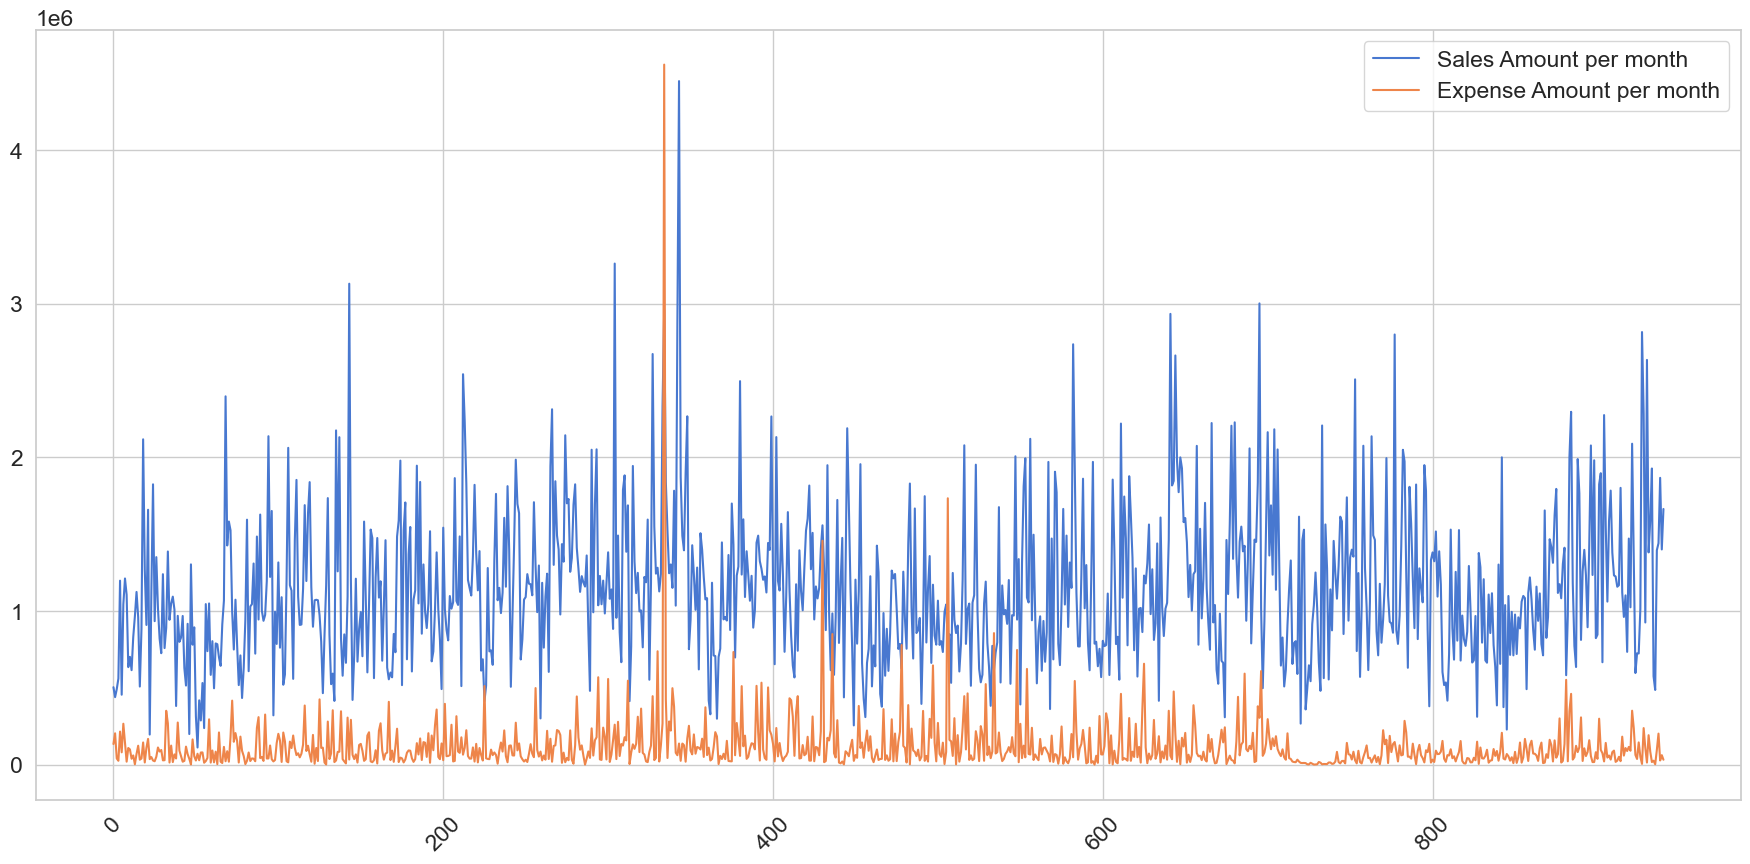

In [35]:
plt.plot(actual['Sales'], label='Sales Amount per month')
plt.plot(actual['Expenses'], label='Expense Amount per month')
plt.legend();
plt.xticks(rotation=45)

In [36]:
columns_to_scale = ['Sales', 'Expenses']

for columns in columns_to_scale:
    hmm[columns] = scaler.fit_transform(np.array(hmm[columns]).reshape(-1, 1))
    
scaled_data = hmm
scaled_data.head()

,Sales,Expenses
0,0.090476,0.029436
1,0.075555,0.044719
2,0.087516,0.008821
3,0.103460,0.005486
4,0.250350,0.047188


In [37]:
# The time series generator takes a sequence of numbers for x and y
# In this case we're sampling the same data, so X and Y have the same data
look_back=4
##################################################

# X = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)
##################################################

def df_to_X_y(df, look_back):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - look_back):
        row = [[a] for a in df_as_np[i:i+look_back]]
        X.append(row)
        label = df_as_np[i+look_back]
        y.append(label)
    return np.array(X), np.array(y)

In [38]:
EDX, EDy = df_to_X_y(scaled_data['Expenses'], look_back)
SDX, SDy = df_to_X_y(scaled_data['Sales'], look_back)
SDy.shape, EDy.shape

((937,), (937,))

In [39]:
SDy = np.expand_dims(SDy, axis=1)
EDy = np.expand_dims(EDy, axis=1)

In [40]:
X = np.concatenate((SDX, EDX), axis=1)
y = np.concatenate((SDy, EDy), axis=1)

In [41]:
# Split into training, testing and val.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42, shuffle=True)
###################################################################################################################

In [42]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val)

(749, 749, 37, 37, 151, 151)

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [44]:
################################################################################################################################
from tensorflow.keras.losses import MeanSquaredError                                                                           #
from tensorflow.keras.metrics import RootMeanSquaredError                                                                      #
from tensorflow.keras.models import Sequential                                                                                 #
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten                                                        #
from tensorflow.keras.callbacks import ModelCheckpoint                                                                         #
from tensorflow.keras.optimizers import Adam                                                                                   #
################################################################################################################################

In [46]:
daily_model = Sequential([
    LSTM(128, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(128, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(2)
])
#Tried relu on LSTM layers, batch size=2, learning rate=0.001, look back=3
#Tried tanh on LSTM layers, batch size=2, learning rate=0.001, look back=4  ***
#

# daily_model = Sequential([
#     LSTM(128, return_sequences=True,activation='relu'),
#     Dropout(0.3),
#     LSTM(128, return_sequences=True,activation='relu'),
#     Dropout(0.3),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation = 'relu'),
#     Dense(2)
# ])

# daily_model = Sequential([
#     LSTM(128, return_sequences=True, activation='tanh'),
#     LSTM(128, return_sequences=True, activation='sigmoid'),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(2)
# ])

# daily_model = Sequential([
#     Bidirectional(LSTM(128, return_sequences=True, activation='relu')),
#     Dropout(0.3),
#     Bidirectional(LSTM(64, activation='relu')),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(2)
# ])

In [49]:
daily_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics = [RootMeanSquaredError()])

In [50]:
daily_model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=200, batch_size=2, verbose=2)

Epoch 1/200
375/375 - 27s - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876 - 27s/epoch - 72ms/step
Epoch 2/200
375/375 - 9s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0831 - 9s/epoch - 25ms/step
Epoch 3/200
375/375 - 10s - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809 - 10s/epoch - 27ms/step
Epoch 4/200
375/375 - 9s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827 - 9s/epoch - 23ms/step
Epoch 5/200
375/375 - 9s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810 - 9s/epoch - 24ms/step
Epoch 6/200
375/375 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804 - 8s/epoch - 21ms/step
Epoch 7/200
375/375 - 10s - loss: 0.0077 - root_mean_squared_error: 0.08

Epoch 54/200
375/375 - 16s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811 - 16s/epoch - 43ms/step
Epoch 55/200
375/375 - 20s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 20s/epoch - 53ms/step
Epoch 56/200
375/375 - 17s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0851 - 17s/epoch - 45ms/step
Epoch 57/200
375/375 - 18s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816 - 18s/epoch - 49ms/step
Epoch 58/200
375/375 - 17s - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - 17s/epoch - 44ms/step
Epoch 59/200
375/375 - 18s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - 18s/epoch - 47ms/step
Epoch 60/200
375/375 - 16s - loss: 0.0075 - root_mean_squa

Epoch 107/200
375/375 - 8s - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801 - 8s/epoch - 21ms/step
Epoch 108/200
375/375 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810 - 8s/epoch - 22ms/step
Epoch 109/200
375/375 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0809 - 8s/epoch - 22ms/step
Epoch 110/200
375/375 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 8s/epoch - 21ms/step
Epoch 111/200
375/375 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 8s/epoch - 21ms/step
Epoch 112/200
375/375 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - 8s/epoch - 21ms/step
Epoch 113/200
375/375 - 8s - loss: 0.0072 - root_mean_squared_er

Epoch 160/200
375/375 - 8s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846 - 8s/epoch - 21ms/step
Epoch 161/200
375/375 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 8s/epoch - 22ms/step
Epoch 162/200
375/375 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832 - 8s/epoch - 21ms/step
Epoch 163/200
375/375 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841 - 8s/epoch - 21ms/step
Epoch 164/200
375/375 - 8s - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - 8s/epoch - 22ms/step
Epoch 165/200
375/375 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799 - 8s/epoch - 21ms/step
Epoch 166/200
375/375 - 8s - loss: 0.0065 - root_mean_squared_er

<Axes: >

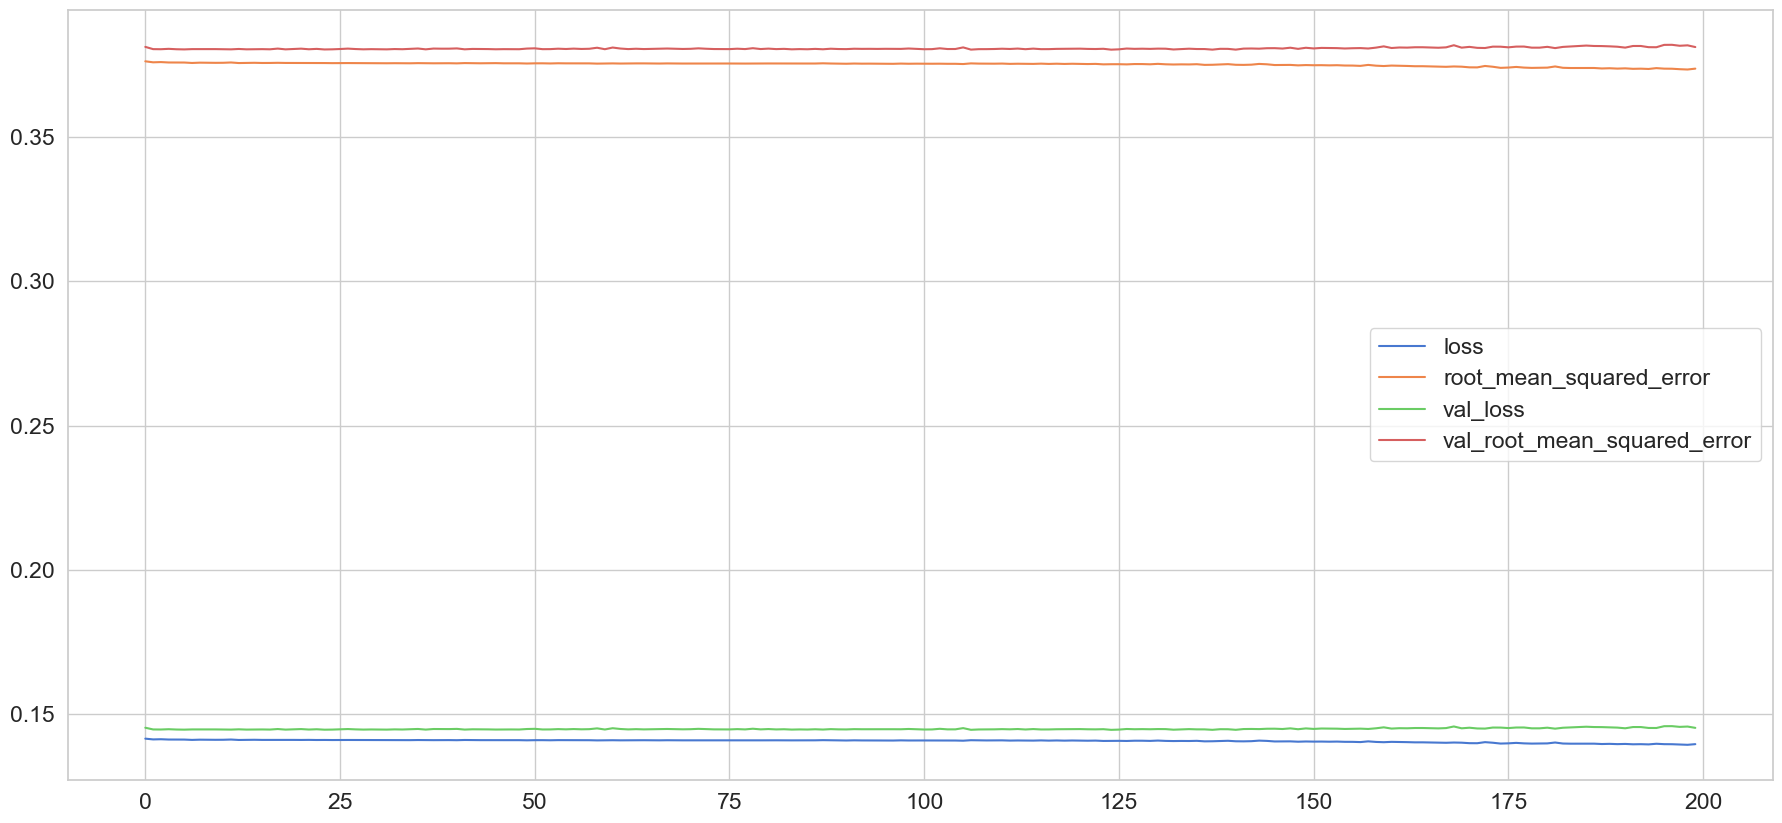

In [27]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [37]:
train_predict=daily_model.predict(X)
train_predict=scaler.inverse_transform(train_predict)
train_predict.shape

30/30 [==============================] - 2s 19ms/step


(937, 2)

In [38]:
df = pd.DataFrame(train_predict, columns=['sales', 'expenses'])
df, len(df)

(            sales       expenses
 0    9.176887e+05   95104.148438
 1    9.990552e+05  106651.140625
 2    9.671528e+05  100520.218750
 3    1.029313e+06  108925.148438
 4    1.099672e+06  117852.367188
 ..            ...            ...
 932  1.029083e+06  100478.781250
 933  1.045902e+06  106140.750000
 934  1.093168e+06  117650.429688
 935  1.215320e+06  134395.609375
 936  1.248270e+06  135798.734375
 
 [937 rows x 2 columns],
 937)

In [39]:
actual = pd.DataFrame(data={'Sales': sdf_daily, 'Expenses':edf_daily})
actual = pd.DataFrame(np.array(actual[look_back:]), columns=['sales', 'expenses'])
actual, len(actual)

(         sales  expenses
 0    1197790.0  215250.0
 1     455345.0   80300.0
 2    1043895.0  266400.0
 3    1212025.0  140000.0
 4    1105848.0   19450.0
 ..         ...       ...
 932  1396202.0   95800.0
 933  1441488.0  202000.0
 934  1867192.0   27101.0
 935  1401098.0   61750.0
 936  1664470.0   32100.0
 
 [937 rows x 2 columns],
 937)

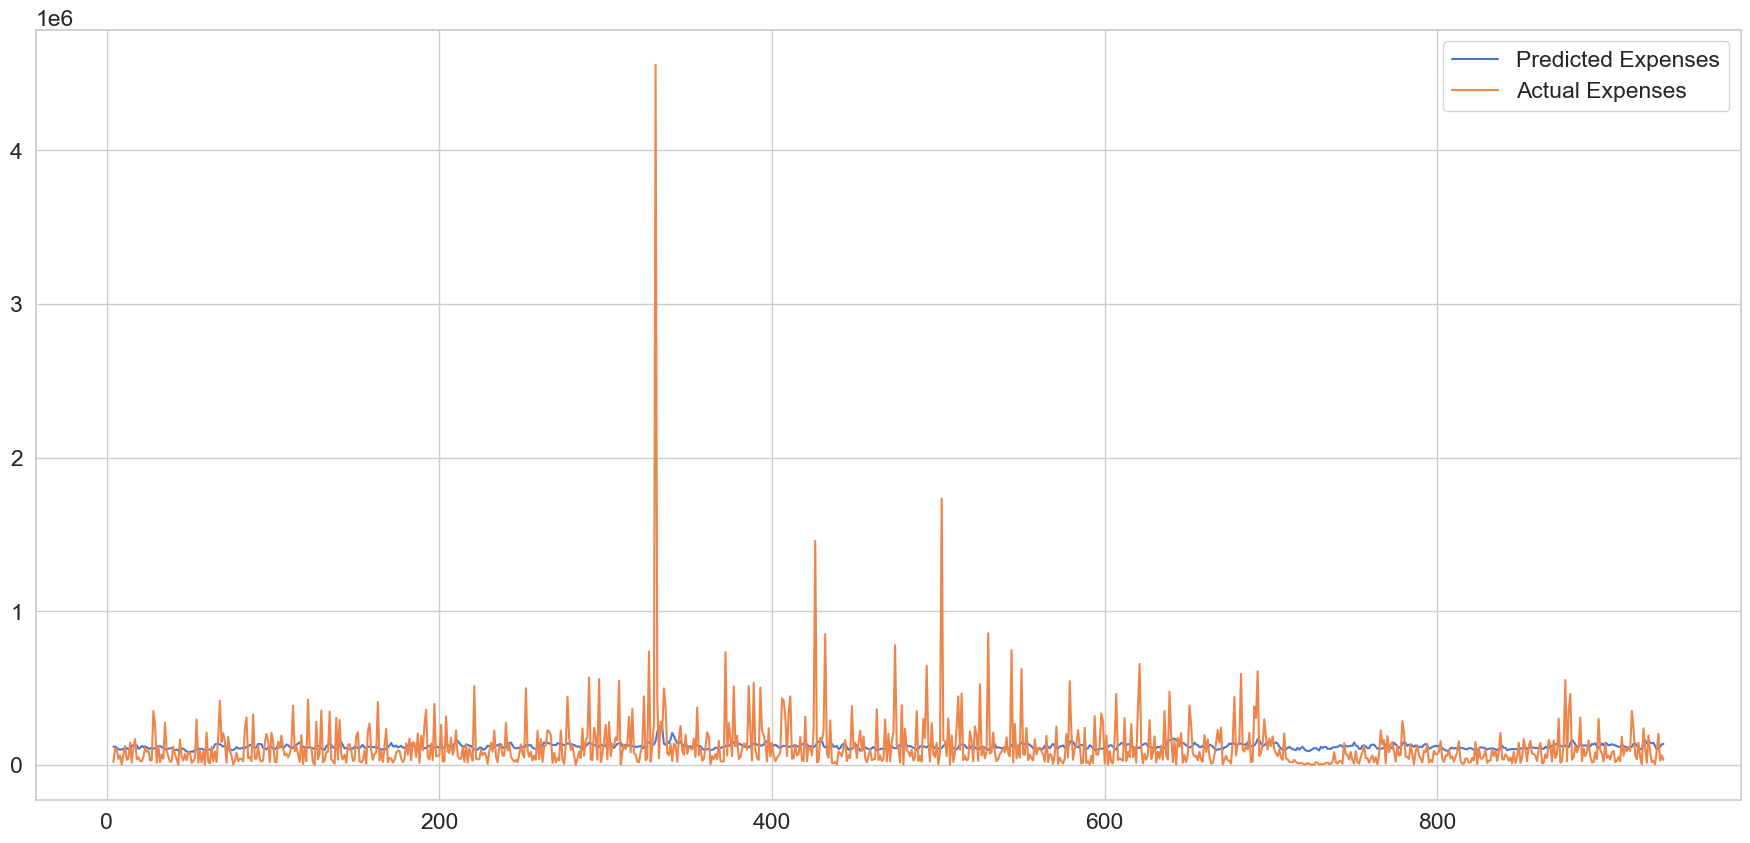

In [40]:
plt.plot(df.index[look_back:], df['expenses'][look_back:], label='Predicted Expenses')
plt.plot(df.index[look_back:], actual['expenses'][look_back:], label='Actual Expenses')
plt.legend()
plt.show()

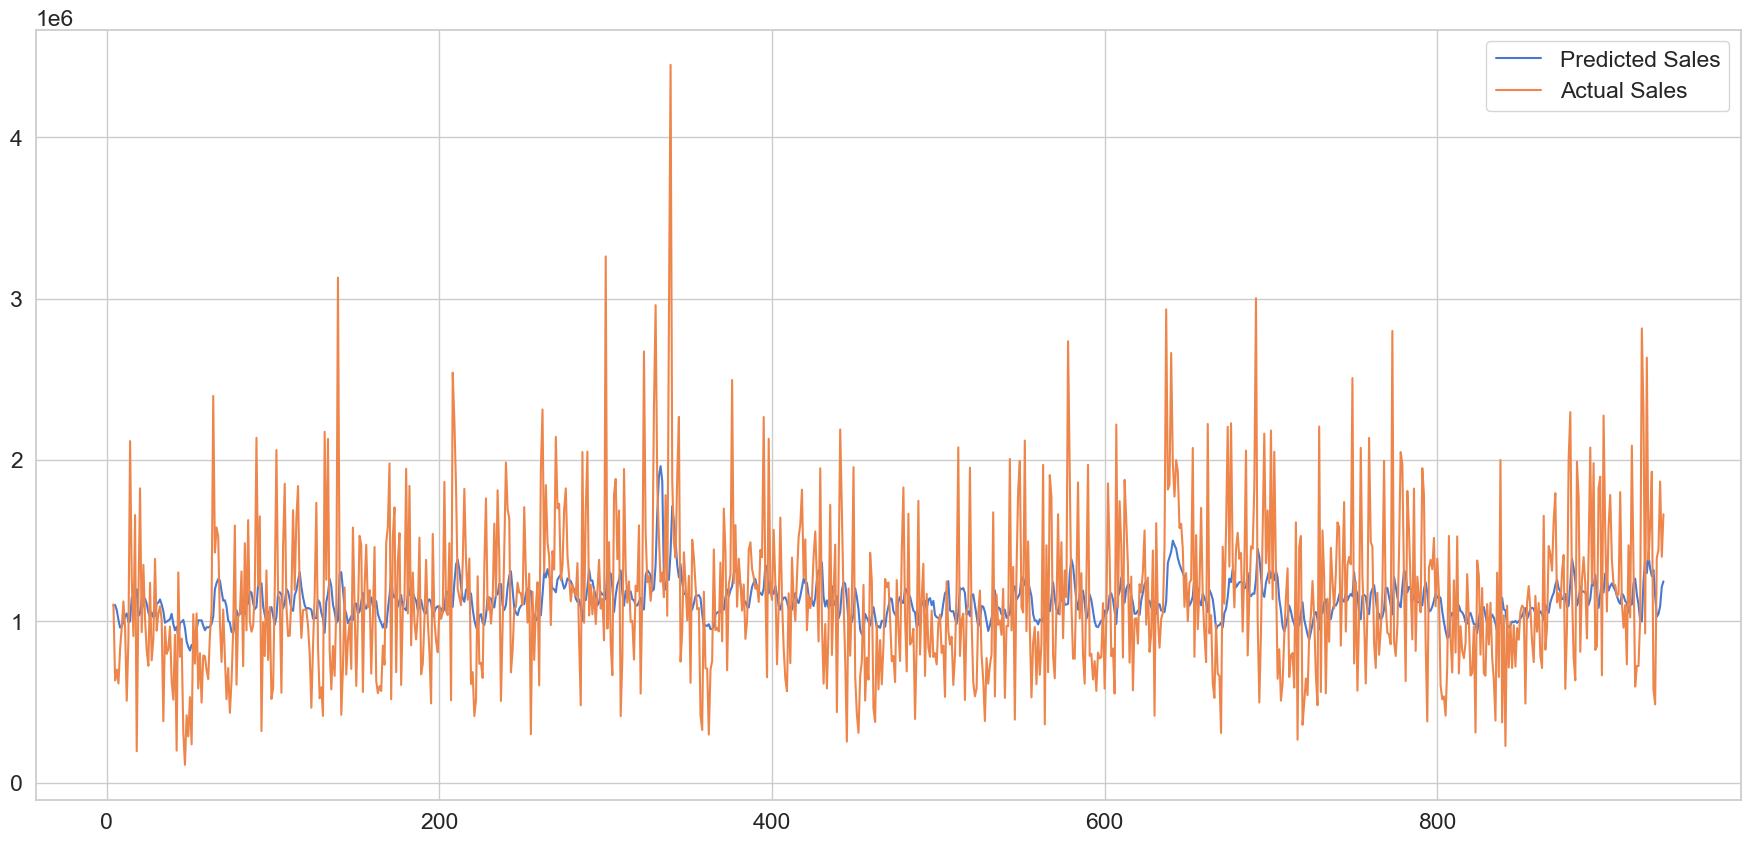

In [41]:
plt.plot(df.index[look_back:], df['sales'][look_back:], label='Predicted Sales')
plt.plot(df.index[look_back:], actual['sales'][look_back:], label='Actual Sales')
plt.legend()
plt.show()